In [1]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
import epyestim.covid19 as c19
from epyestim.distributions import discretise_gamma
import multiprocessing as mp
import itertools
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import pickle  

In [2]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, transition_dates, ltla):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[ltla].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas, ltla_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            transition_dates = ltla_transitions[ltla]
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, transition_dates, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict

# Get detect indices for timeline
from operator import itemgetter

def detect(arr):
    if len(arr) < 3:
        return []

    values = []
    i = 0
    while i < len(arr) - 2:
        if arr[i] + 1 == arr[i + 1] and arr[i + 1] + 1 == arr[i + 2]:
            values.append(arr[i + 2])
            while i + 2 < len(arr) - 1 and arr[i + 2] + 1 == arr[i + 3]:
                i += 1
        i += 1
    
    return values

In [3]:
wide_data_total = pd.read_csv('Data/wide_total.csv')
wide_data_total['date'] = pd.to_datetime(wide_data_total['date'])
wide_data_total.set_index('date',inplace=True)
weekly_counts_total = pd.read_csv('Data/weekly_total.csv')
weekly_counts_total['date'] = pd.to_datetime(weekly_counts_total['date'])
weekly_counts_total.set_index('date',inplace=True)
cases = pd.read_csv('Data/cases_total.csv')
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date',inplace=True)
npis = pd.read_csv('Data/ltla_to_nhs.csv')

In [4]:
# Get signals long windows
ews_10total, norm_ews_10total = calculate_ews_rolling(wide_data_total,window_size=10)
ews_30total, norm_ews_30total = calculate_ews_rolling(wide_data_total,window_size=30)

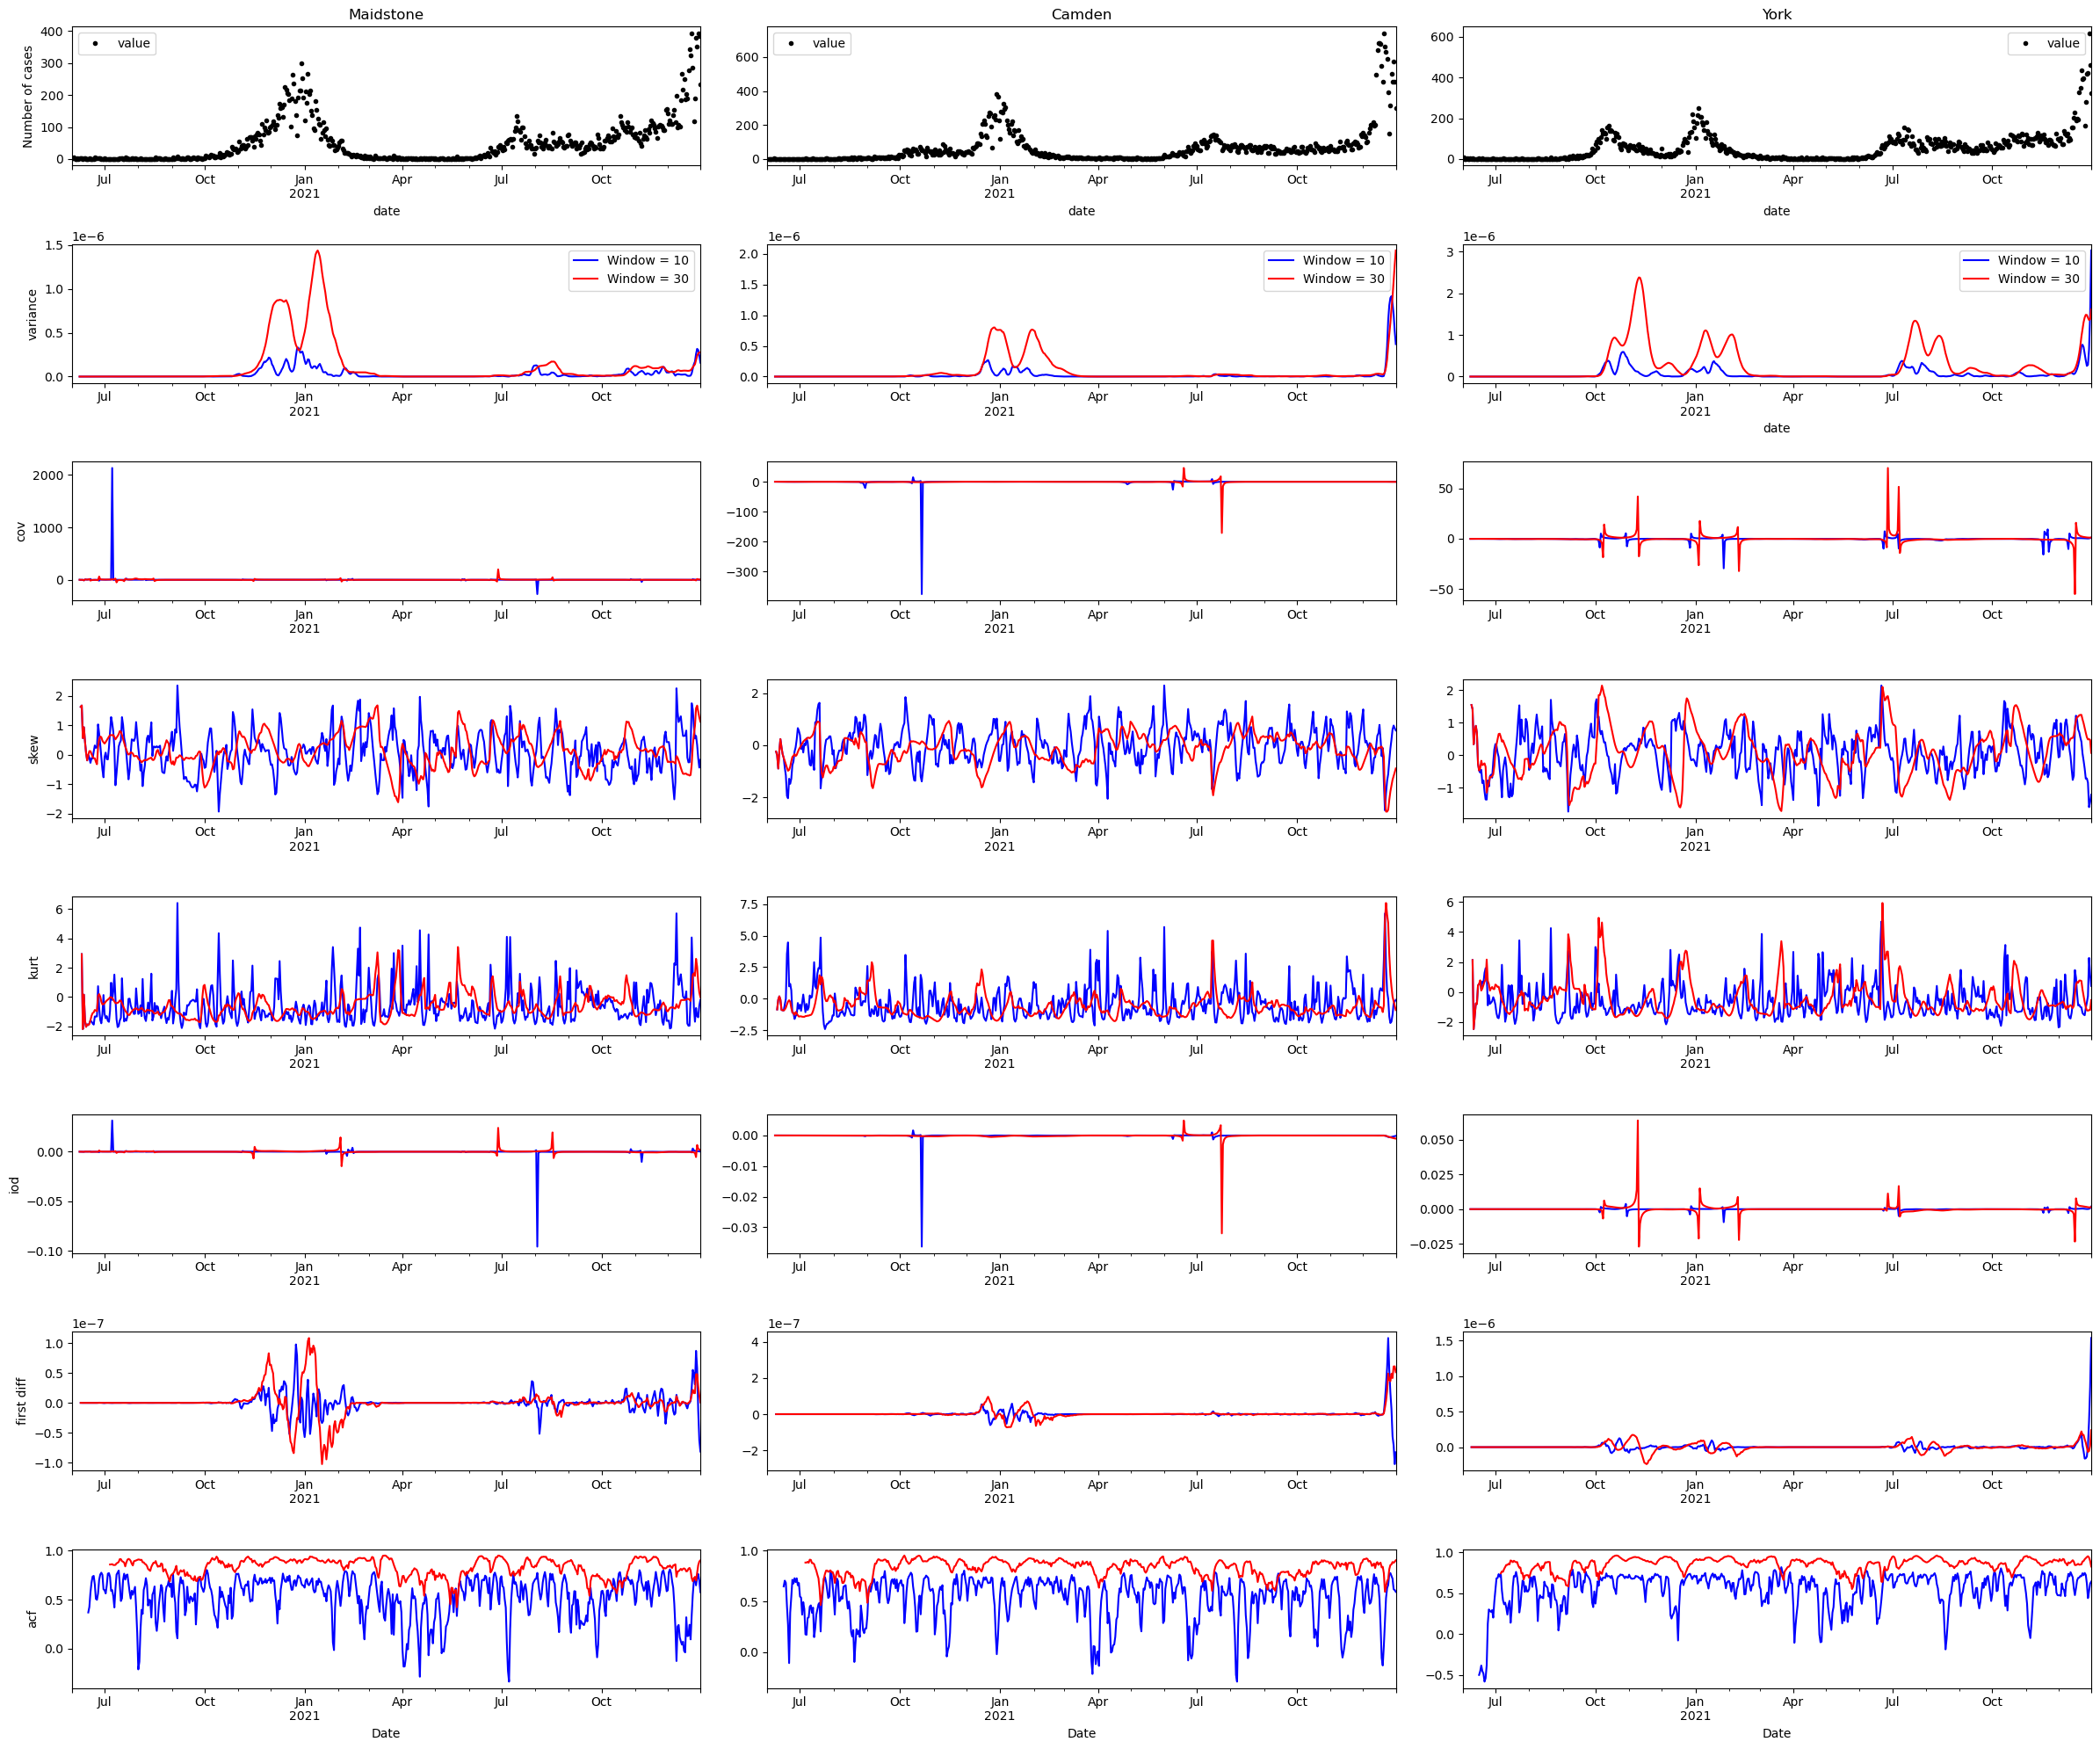

In [5]:
fig, axs = plt.subplots(nrows=len(ews_10total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')


for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_30total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,0],color='red',label='Window = 30')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_30total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,1],color='red',label='Window = 30')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['York']
    stat_data = ews_30total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,2],color='red',label='Window = 30')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.tight_layout()
plt.savefig("Figures/spatialrolling1030.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [6]:
with open('Data/ltla_transitions.pkl', 'rb') as f:
    ltla_transitions = pickle.load(f)
ews_dict = norm_ews_30total
areas = np.unique(ews_30total['variance'].columns.values)
ltlas = ['Maidstone','Camden','York']
two_sigma_cutoff, mean_dict, std_dict = loop_EWSs_store_results_cutoffs(ews_dict, areas, ltla_transitions)

/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtyp

/tmp/ipykernel_241434/4113691846.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['rolling'] = counts['value'].rolling(7).mean()
/tmp/ipykernel_241434/4113691846.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['rolling'] = counts['value'].rolling(7).mean()
/tmp/ipykernel_241434/4113691846.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

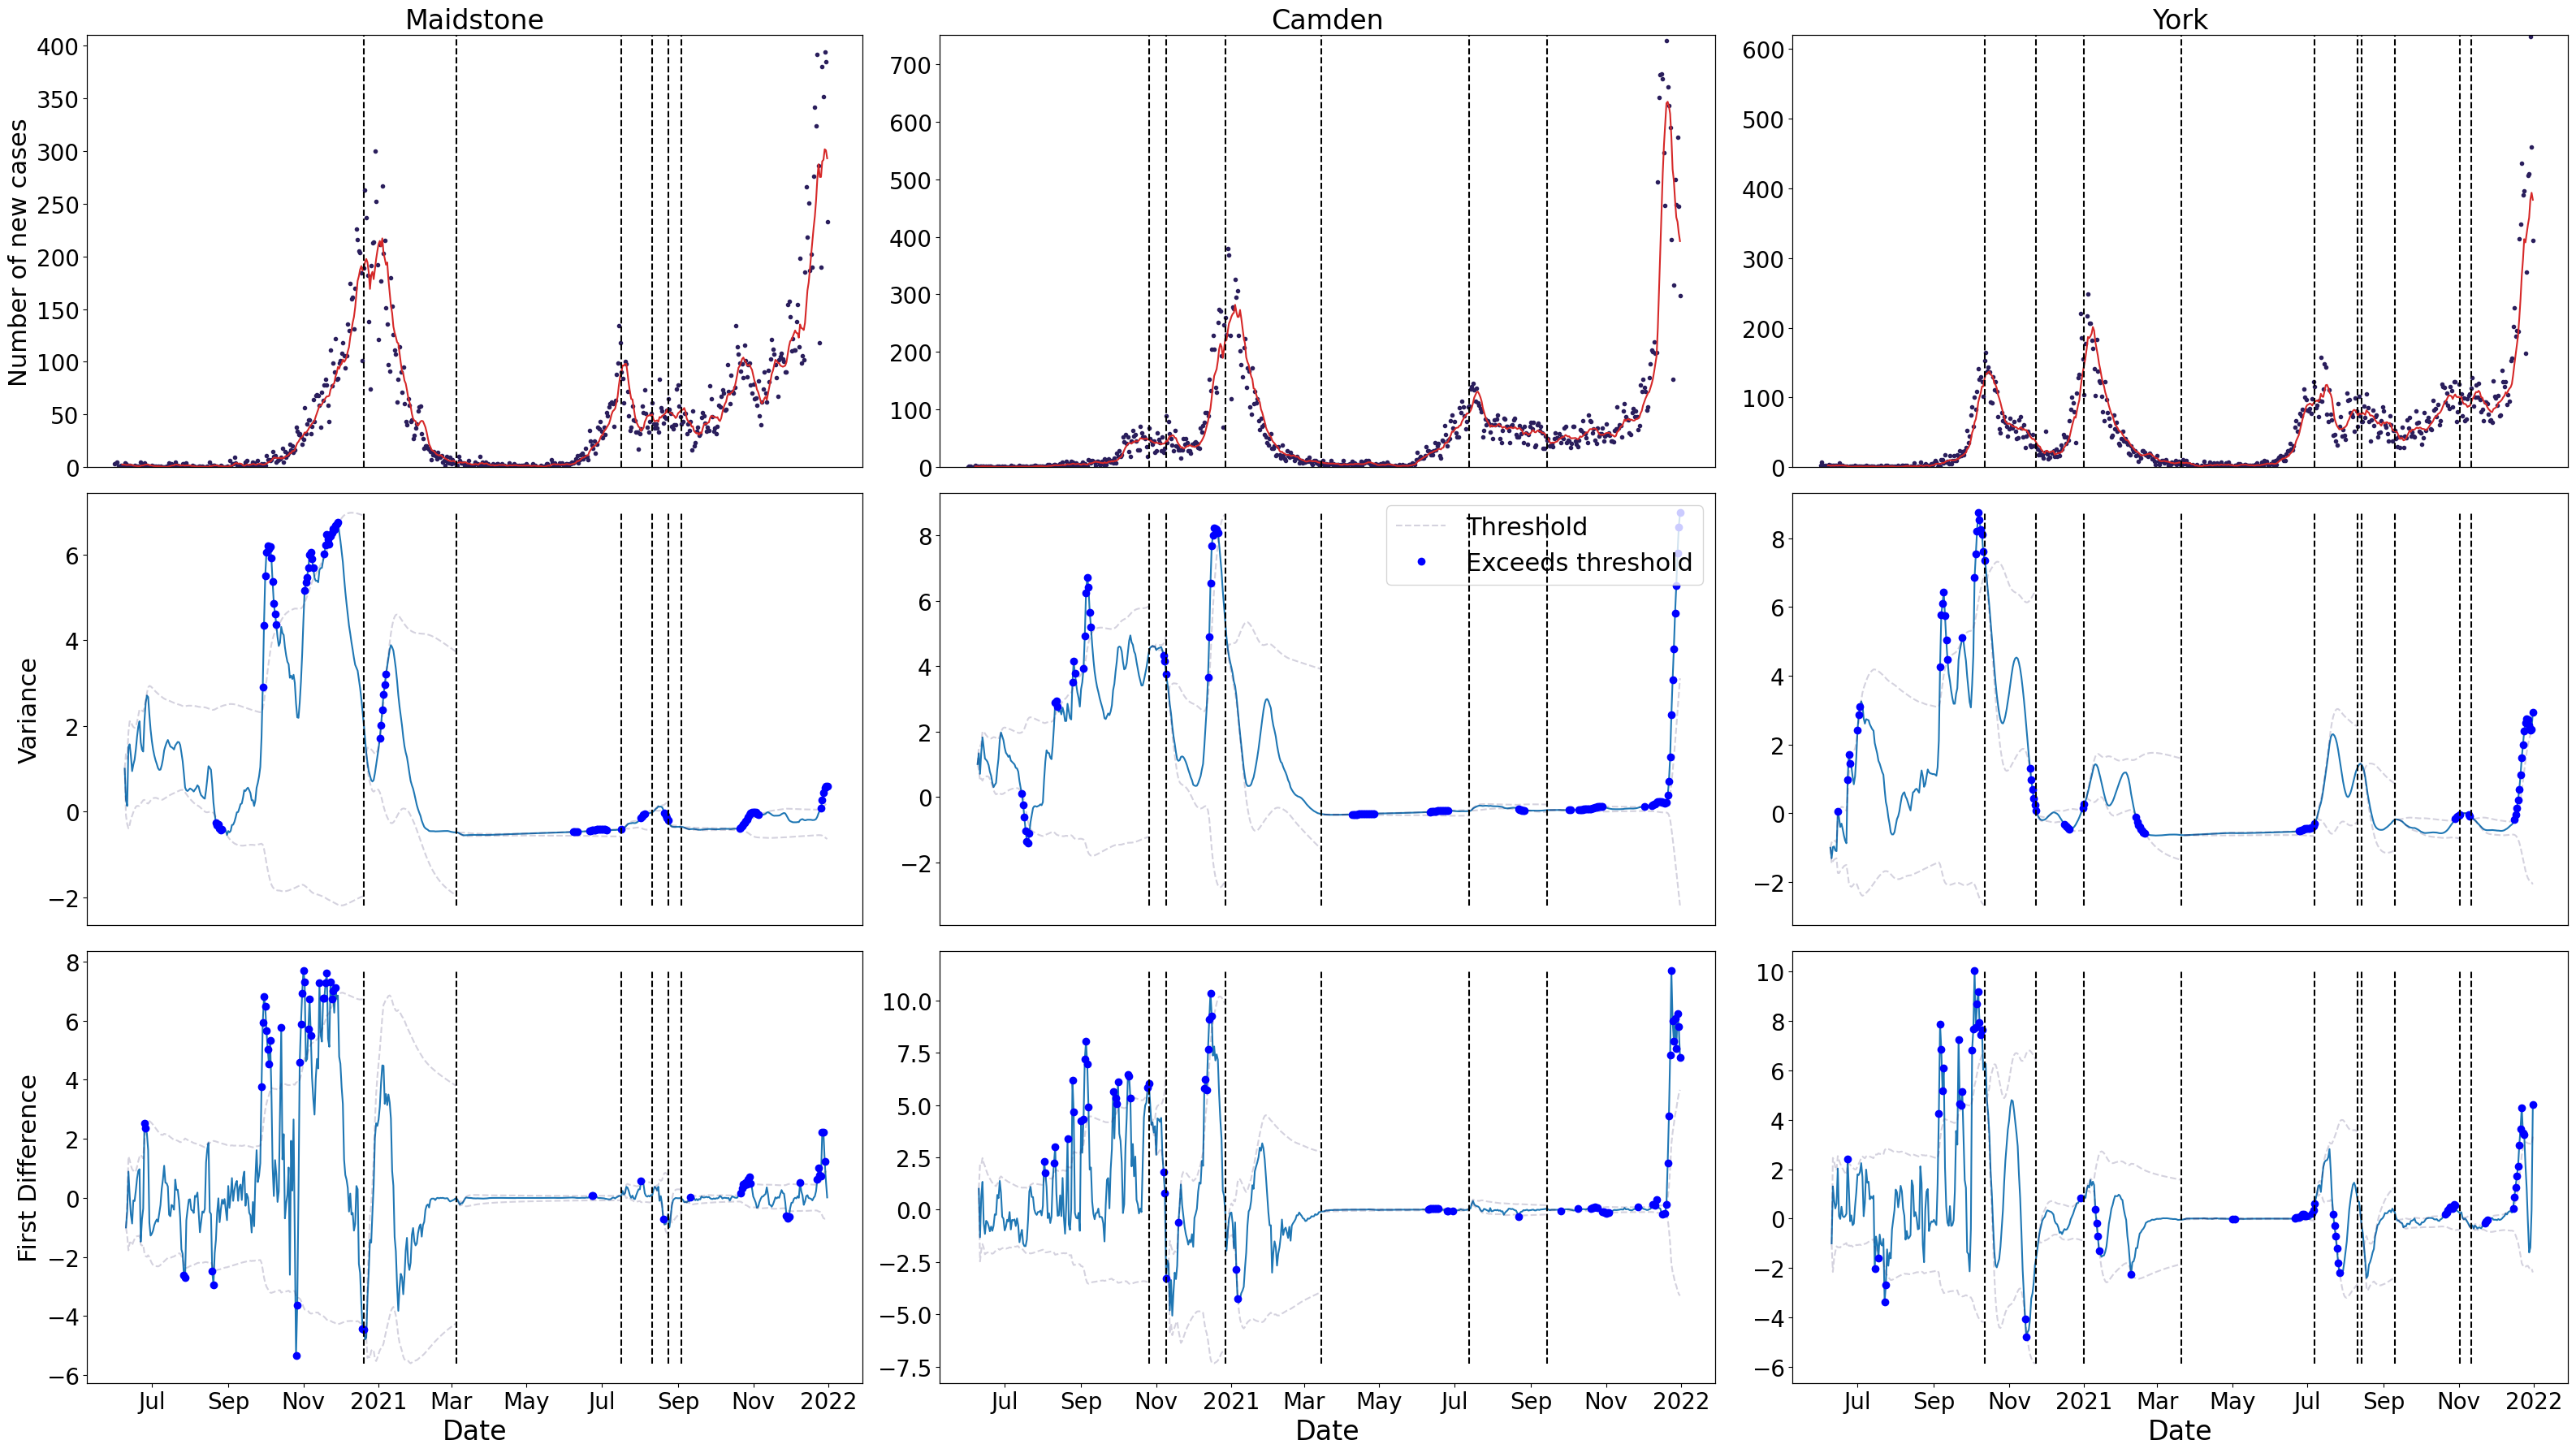

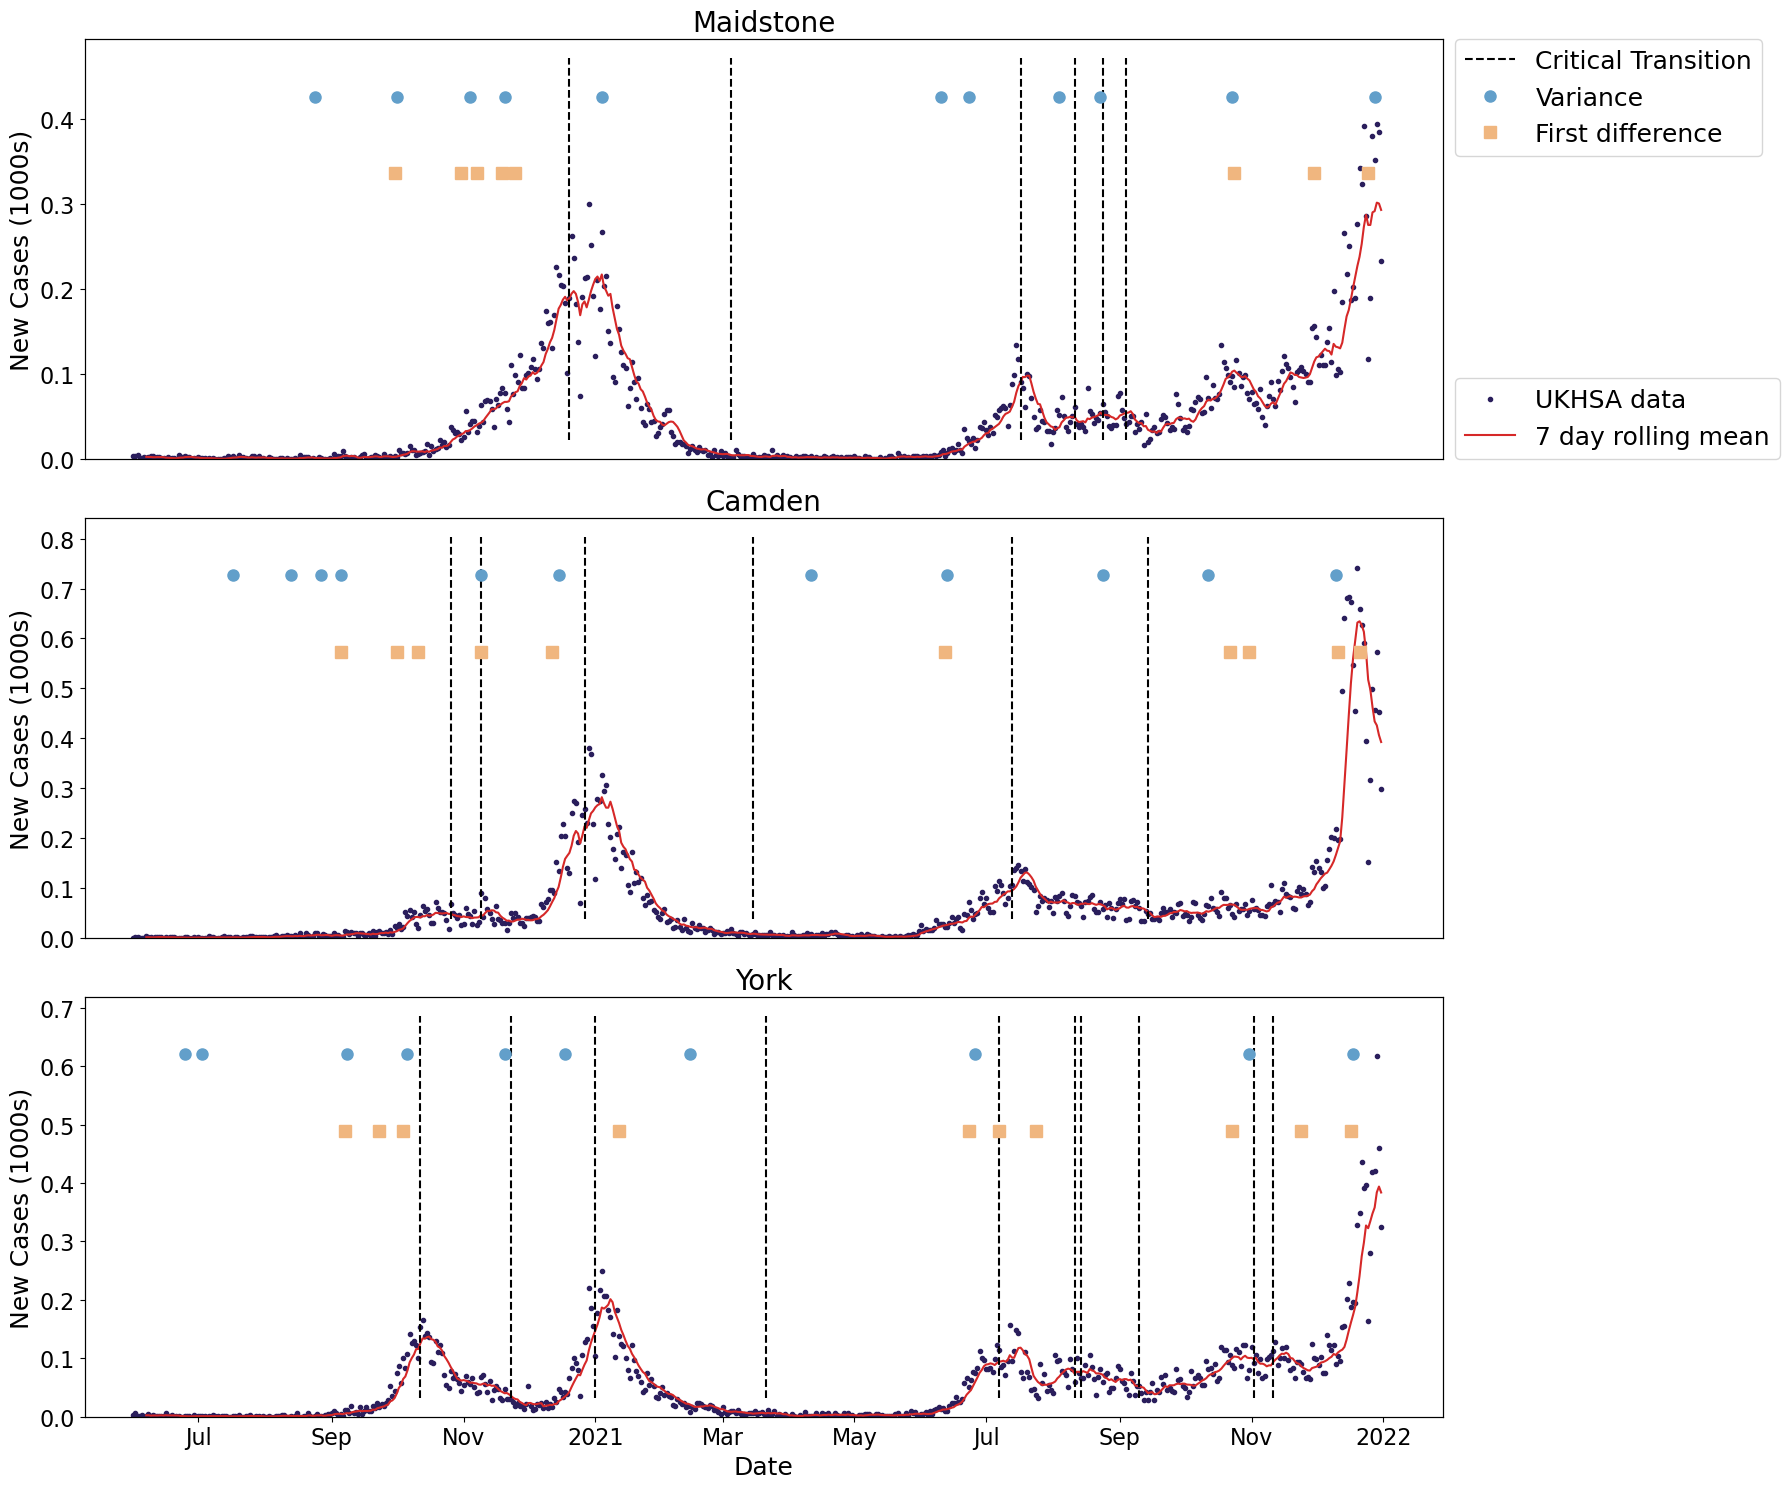

In [7]:
detect_var = {}
detect_fd = {}

for area in areas:
    detect_var[area] = detect(two_sigma_cutoff['variance'][area])
    detect_fd[area] = detect(two_sigma_cutoff['first diff'][area])

stats = ['variance', 'first diff']
labs = ['Variance','First Difference']
fig, axs = plt.subplots(nrows=len(stats)+1,ncols=3,figsize=(32,18))
counts = cases[cases['area_name']=='Maidstone']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,0].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,0].plot(counts['date'],counts['rolling'],color='#D62828')
# counts.plot()
axs[0,0].set_ylim((0,410))
axs[0,0].set_title('Maidstone',fontsize=24)
counts = cases[cases['area_name']=='Camden']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,1].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,1].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,1].set_ylim((0,750))
axs[0,1].set_title('Camden',fontsize=24)
counts = cases[cases['area_name']=='York']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,2].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,2].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,2].set_title('York',fontsize=24)
axs[0,2].set_ylim((0,620))
axs[0,0].set_ylabel('Number of new cases',fontsize=22)
ax = axs[0,0].twinx()
ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,1].twinx()
ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,2].twinx()
ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[0,i].xaxis.label.set_visible(False)
    axs[0,i].tick_params(axis='x', labelsize=20)
    axs[0,i].tick_params(axis='y', labelsize=20)

for i, stat in enumerate(stats):
    stat_data = norm_ews_30total[stat]
    y_data = stat_data['Maidstone'].copy(deep=True)
    std_val = std_dict[stat]['Maidstone']
    mean_val = mean_dict[stat]['Maidstone']
    axs[i+1,0].plot(y_data.reset_index()['date'],y_data.reset_index()['Maidstone'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,0].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,0].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Maidstone']].drop(columns=['Top','Bottom'])
    axs[i+1,0].plot(y_data['date'],y_data['Maidstone'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,0].xaxis.label.set_visible(False)
    axs[i+1,0].tick_params(axis='x', labelsize=20)
    axs[i+1,0].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,0].twinx()
    ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])    
    
for i, stat in enumerate(stats):
    stat_data = norm_ews_30total[stat]
    y_data = stat_data['Camden'].copy(deep=True)
    std_val = std_dict[stat]['Camden']
    mean_val = mean_dict[stat]['Camden']
    axs[i+1,1].plot(y_data.reset_index()['date'],y_data.reset_index()['Camden'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,1].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,1].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Camden']].drop(columns=['Top','Bottom'])
    axs[i+1,1].plot(y_data['date'],y_data['Camden'],'o',color='blue',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,1].legend(fontsize=22)
    axs[i+1,1].xaxis.label.set_visible(False)
    axs[i+1,1].tick_params(axis='x', labelsize=20)
    axs[i+1,1].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,1].twinx()
    ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i, stat in enumerate(stats):
    stat_data = norm_ews_30total[stat]
    y_data = stat_data['York'].copy(deep=True)
    std_val = std_dict[stat]['York']
    mean_val = mean_dict[stat]['York']
    axs[i+1,2].plot(y_data.reset_index()['date'],y_data.reset_index()['York'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,2].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,2].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['York']].drop(columns=['Top','Bottom'])
    axs[i+1,2].plot(y_data['date'],y_data['York'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,2].xaxis.label.set_visible(False)
    axs[i+1,2].tick_params(axis='x', labelsize=20)
    axs[i+1,2].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,2].twinx()
    ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=24)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

for i in range(1,3):
    axs[i,0].set_ylabel(labs[i-1],fontsize=22)

for i in range(3):
    for j in range(3):
        if i < 2:
            axs[i,j].set_xticks(())
        else:
            axs[i,j].xaxis.set_major_formatter(mdates.ConciseDateFormatter((axs[i,j].xaxis.get_major_locator())))
        axs[i,j].set_xlim((18391.4, 19020.6))

fig.tight_layout()
# plt.savefig("Figures/spatialrolling2sigmacutoff.pdf",dpi=2400,bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(3,1,figsize=(18,15))
for i, region in enumerate(ltlas):

    counts =  cases[cases['area_name']==region].reset_index()
    counts['value'] = counts['value'] / 1000
    counts['rolling'] = counts['value'].rolling(7).mean()
    axs[i].plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    axs[i].plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    axs[i].set_ylim([0,np.max(counts['value'].values)+0.1])
    axs[i].set_title(region,fontsize=20)
    # ax.get_yaxis().set_ticks([])
    axs[i].set_ylabel('New Cases (1000s)',fontsize=18)
    axs[i].tick_params(axis='y',labelsize=16)

    ax = axs[i].twinx()
    ax.vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_30total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    ax.plot(xs,[0.8]*len(xs),'o',color='#629FCA',markersize=8,label='Variance')

    signal_data = norm_ews_30total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    ax.plot(xs,[0.4]*len(xs),'s',color='#F0B67F',markersize=8,label='First difference')

    ax.get_yaxis().set_ticks([])
    if i == 0:
        ax.legend(loc='upper left',fontsize = 18, bbox_to_anchor=(1, 1.03))

for i in range(3):
    axs[i].set_xlim(((18391.4, 19020.6)))
    if i < 2:
        axs[i].set_xticks(())
    else:
        axs[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[i].xaxis.get_major_locator()))
        axs[i].tick_params(axis='x', labelsize=16)
axs[0].legend(loc='lower left',fontsize = 18, bbox_to_anchor=(1, -0.03))
axs[-1].set_xlabel('Date',fontsize=18)
plt.tight_layout()
plt.savefig('Figures/ltla_timeline_30_days_outlegend.pdf',dpi=1200,bbox_inches='tight')
plt.show()

/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtyp

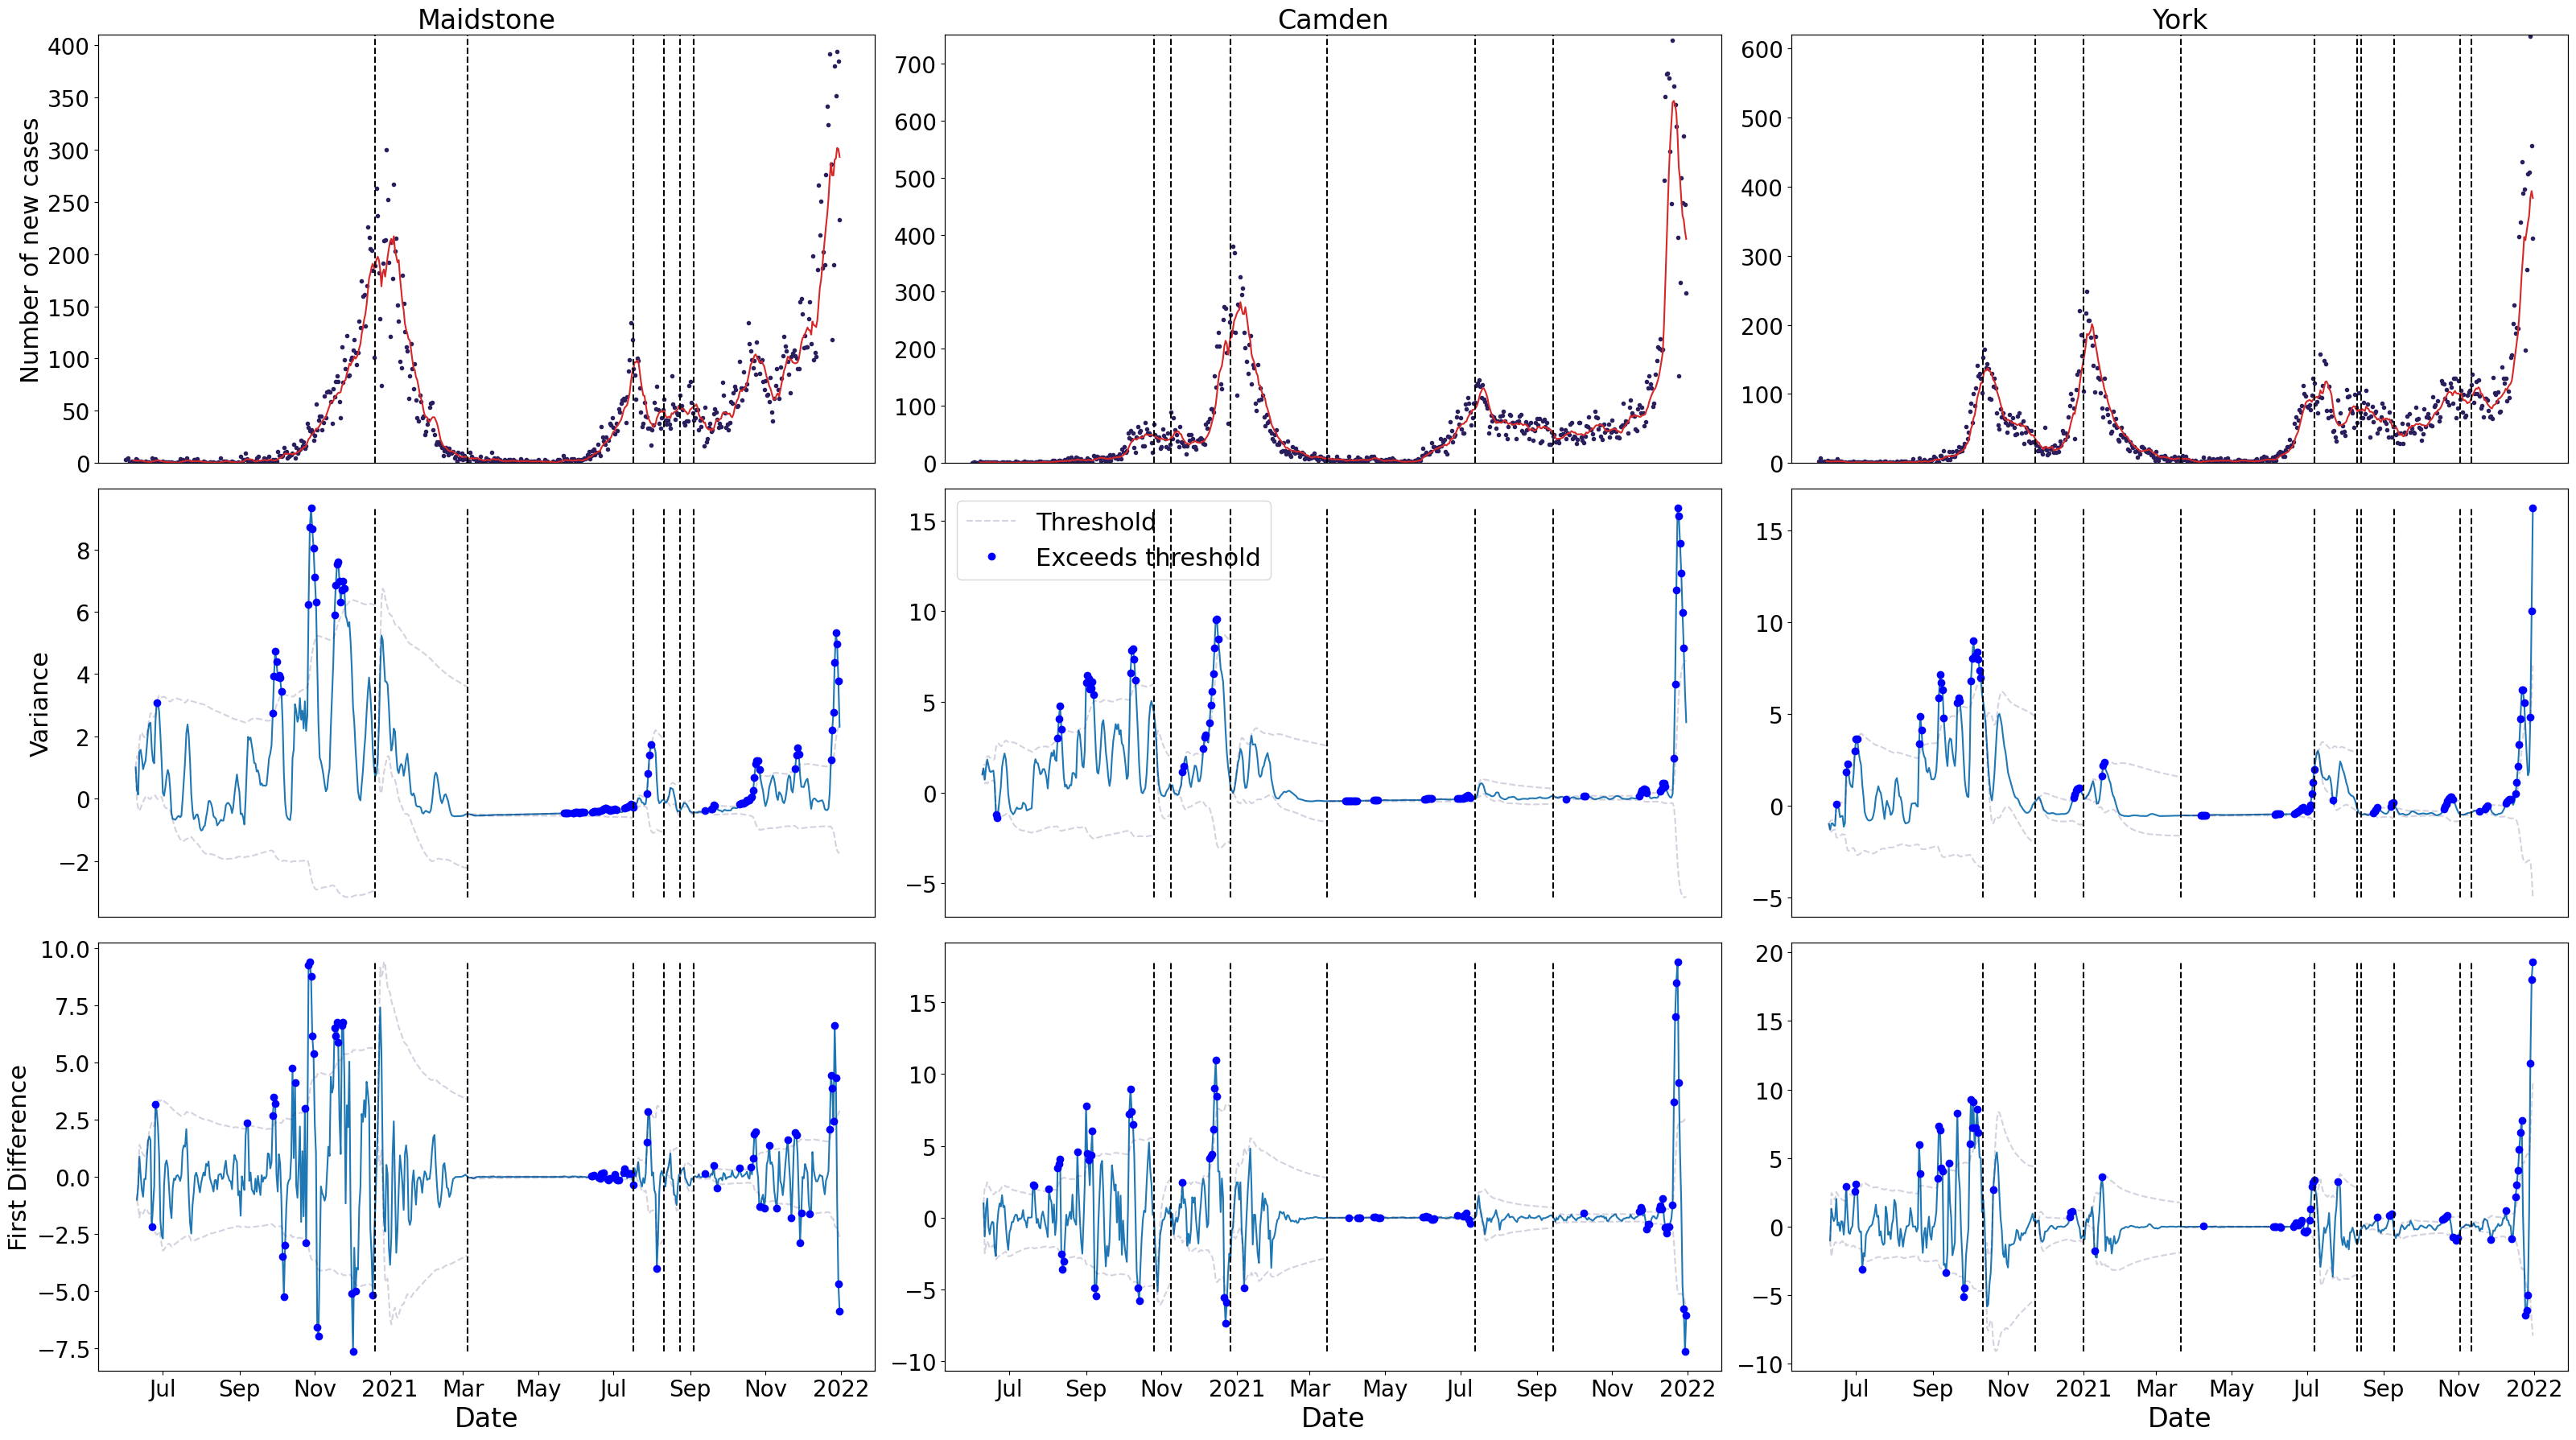

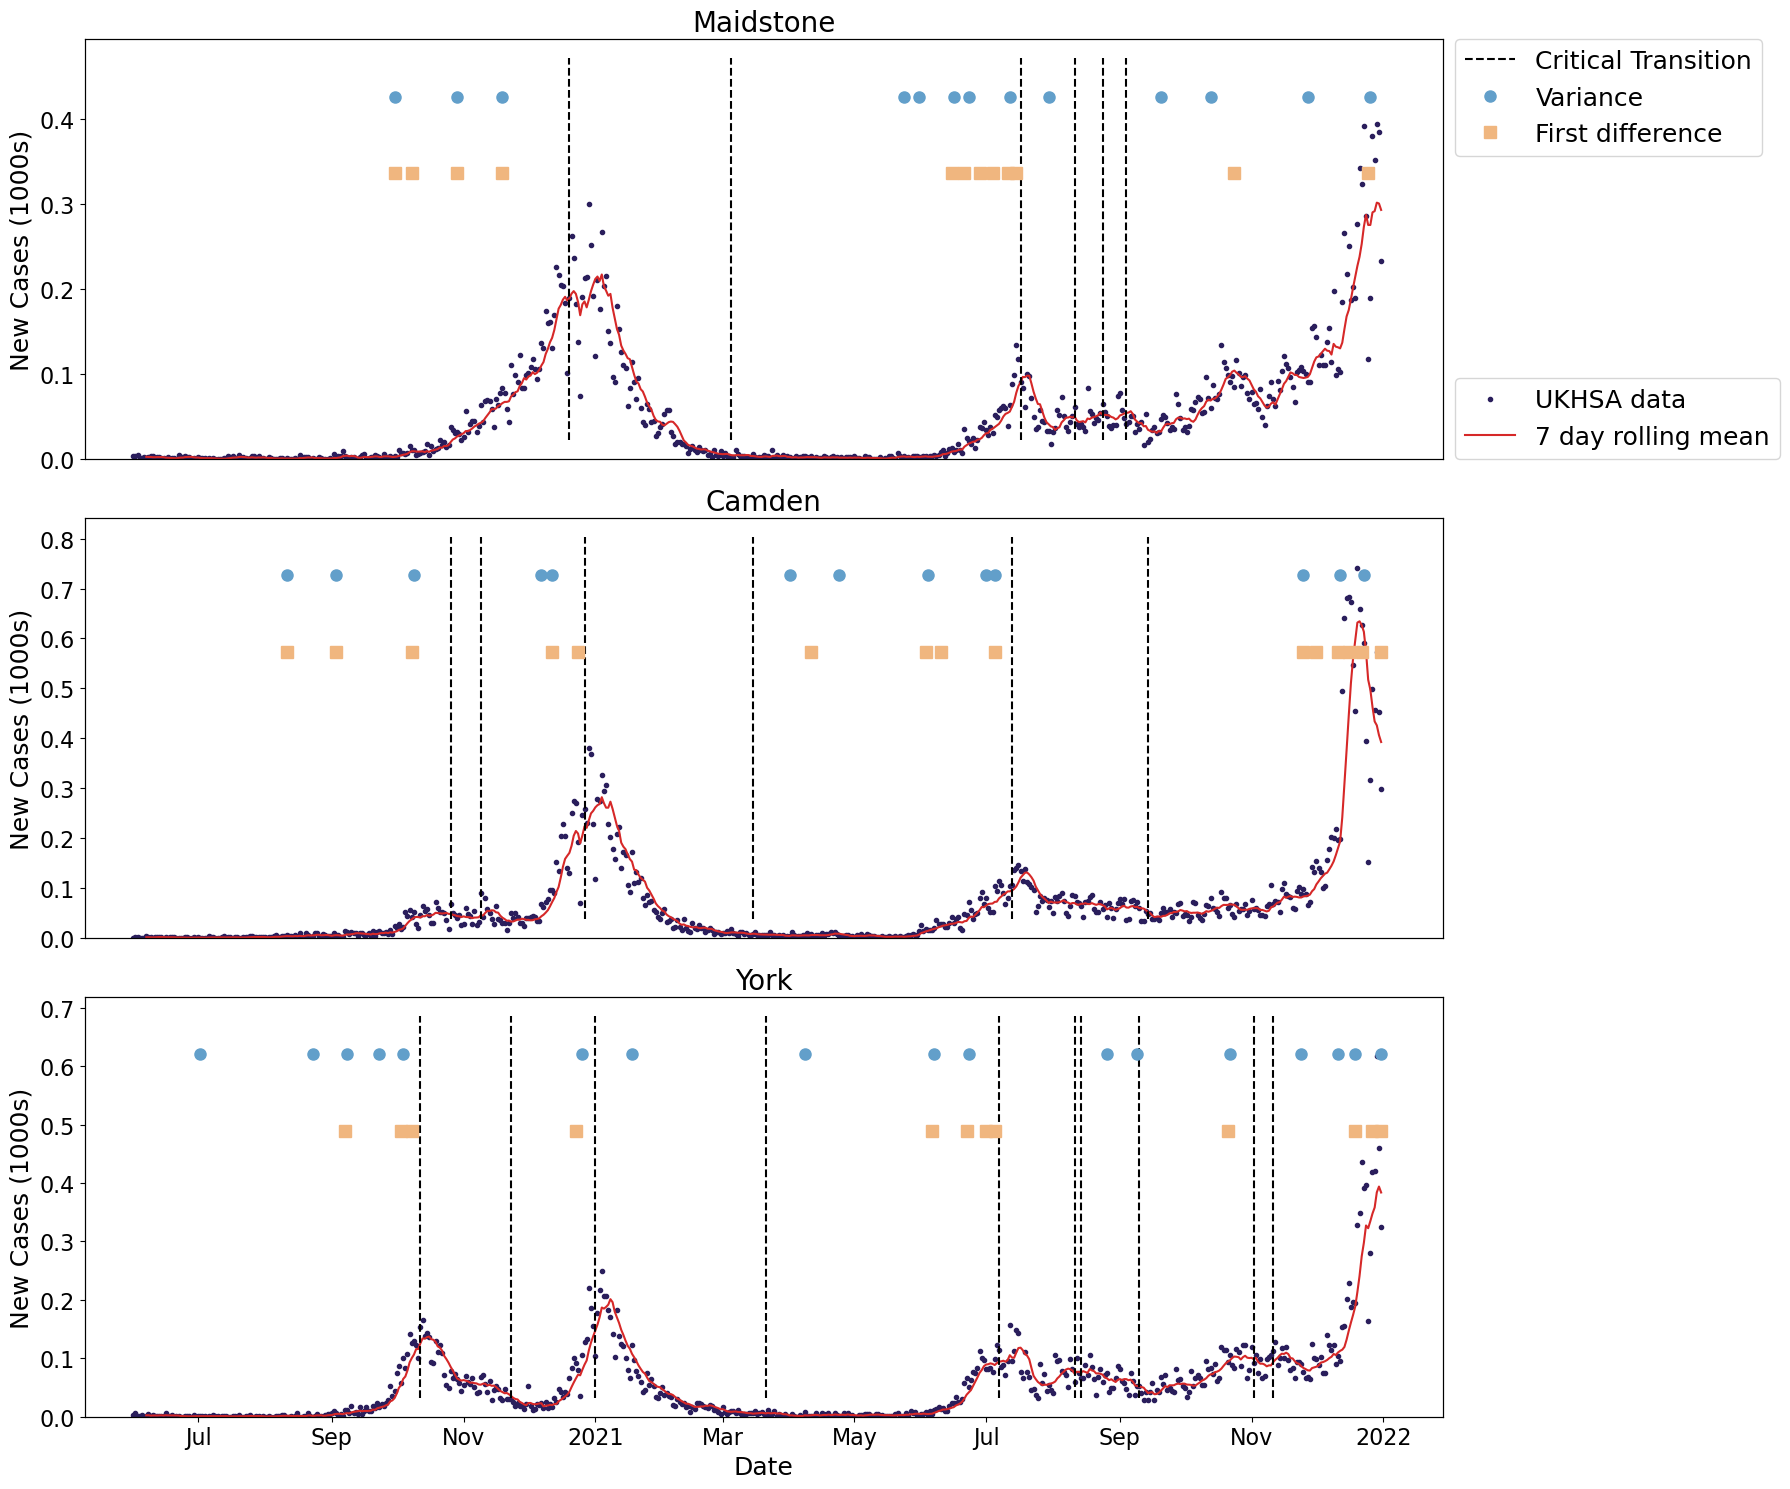

In [8]:
ews_dict = norm_ews_10total
areas = np.unique(ews_30total['variance'].columns.values)
ltlas = ['Maidstone','Camden','York']
two_sigma_cutoff, mean_dict, std_dict = loop_EWSs_store_results_cutoffs(ews_dict, areas, ltla_transitions)

detect_var = {}
detect_fd = {}

for area in areas:
    detect_var[area] = detect(two_sigma_cutoff['variance'][area])
    detect_fd[area] = detect(two_sigma_cutoff['first diff'][area])

stats = ['variance', 'first diff']
labs = ['Variance','First Difference']
fig, axs = plt.subplots(nrows=len(stats)+1,ncols=3,figsize=(32,18))
counts = cases[cases['area_name']=='Maidstone']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,0].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,0].plot(counts['date'],counts['rolling'],color='#D62828')
# counts.plot()
axs[0,0].set_ylim((0,410))
axs[0,0].set_title('Maidstone',fontsize=24)
counts = cases[cases['area_name']=='Camden']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,1].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,1].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,1].set_ylim((0,750))
axs[0,1].set_title('Camden',fontsize=24)
counts = cases[cases['area_name']=='York']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,2].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,2].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,2].set_title('York',fontsize=24)
axs[0,2].set_ylim((0,620))
axs[0,0].set_ylabel('Number of new cases',fontsize=22)
ax = axs[0,0].twinx()
ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,1].twinx()
ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,2].twinx()
ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[0,i].xaxis.label.set_visible(False)
    axs[0,i].tick_params(axis='x', labelsize=20)
    axs[0,i].tick_params(axis='y', labelsize=20)

for i, stat in enumerate(stats):
    stat_data = norm_ews_10total[stat]
    y_data = stat_data['Maidstone'].copy(deep=True)
    std_val = std_dict[stat]['Maidstone']
    mean_val = mean_dict[stat]['Maidstone']
    axs[i+1,0].plot(y_data.reset_index()['date'],y_data.reset_index()['Maidstone'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,0].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,0].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Maidstone']].drop(columns=['Top','Bottom'])
    axs[i+1,0].plot(y_data['date'],y_data['Maidstone'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,0].xaxis.label.set_visible(False)
    axs[i+1,0].tick_params(axis='x', labelsize=20)
    axs[i+1,0].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,0].twinx()
    ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])    
    
for i, stat in enumerate(stats):
    stat_data = norm_ews_10total[stat]
    y_data = stat_data['Camden'].copy(deep=True)
    std_val = std_dict[stat]['Camden']
    mean_val = mean_dict[stat]['Camden']
    axs[i+1,1].plot(y_data.reset_index()['date'],y_data.reset_index()['Camden'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,1].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,1].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Camden']].drop(columns=['Top','Bottom'])
    axs[i+1,1].plot(y_data['date'],y_data['Camden'],'o',color='blue',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,1].legend(fontsize=22)
    axs[i+1,1].xaxis.label.set_visible(False)
    axs[i+1,1].tick_params(axis='x', labelsize=20)
    axs[i+1,1].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,1].twinx()
    ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i, stat in enumerate(stats):
    stat_data = norm_ews_10total[stat]
    y_data = stat_data['York'].copy(deep=True)
    std_val = std_dict[stat]['York']
    mean_val = mean_dict[stat]['York']
    axs[i+1,2].plot(y_data.reset_index()['date'],y_data.reset_index()['York'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,2].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,2].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['York']].drop(columns=['Top','Bottom'])
    axs[i+1,2].plot(y_data['date'],y_data['York'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,2].xaxis.label.set_visible(False)
    axs[i+1,2].tick_params(axis='x', labelsize=20)
    axs[i+1,2].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,2].twinx()
    ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=24)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

for i in range(1,3):
    axs[i,0].set_ylabel(labs[i-1],fontsize=22)

for i in range(3):
    for j in range(3):
        if i < 2:
            axs[i,j].set_xticks(())
        else:
            axs[i,j].xaxis.set_major_formatter(mdates.ConciseDateFormatter((axs[i,j].xaxis.get_major_locator())))
        axs[i,j].set_xlim((18391.4, 19020.6))

fig.tight_layout()
# plt.savefig("Figures/spatialrolling2sigmacutoff.pdf",dpi=2400,bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(3,1,figsize=(18,15))
for i, region in enumerate(ltlas):

    counts =  cases[cases['area_name']==region].reset_index()
    counts['value'] = counts['value'] / 1000
    counts['rolling'] = counts['value'].rolling(7).mean()
    axs[i].plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    axs[i].plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    axs[i].set_ylim([0,np.max(counts['value'].values)+0.1])
    axs[i].set_title(region,fontsize=20)
    # ax.get_yaxis().set_ticks([])
    axs[i].set_ylabel('New Cases (1000s)',fontsize=18)
    axs[i].tick_params(axis='y',labelsize=16)

    ax = axs[i].twinx()
    ax.vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_10total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    ax.plot(xs,[0.8]*len(xs),'o',color='#629FCA',markersize=8,label='Variance')

    signal_data = norm_ews_10total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    ax.plot(xs,[0.4]*len(xs),'s',color='#F0B67F',markersize=8,label='First difference')

    ax.get_yaxis().set_ticks([])
    if i == 0:
        ax.legend(loc='upper left',fontsize = 18, bbox_to_anchor=(1, 1.03))

for i in range(3):
    axs[i].set_xlim(((18391.4, 19020.6)))
    if i < 2:
        axs[i].set_xticks(())
    else:
        axs[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[i].xaxis.get_major_locator()))
        axs[i].tick_params(axis='x', labelsize=16)
axs[0].legend(loc='lower left',fontsize = 18, bbox_to_anchor=(1, -0.03))
axs[-1].set_xlabel('Date',fontsize=18)
plt.tight_layout()
plt.savefig('Figures/ltla_timeline_10_days_outlegend.pdf',dpi=1200,bbox_inches='tight')
plt.show()

In [9]:
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)

/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_241434/1506497420.py:41: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtyp

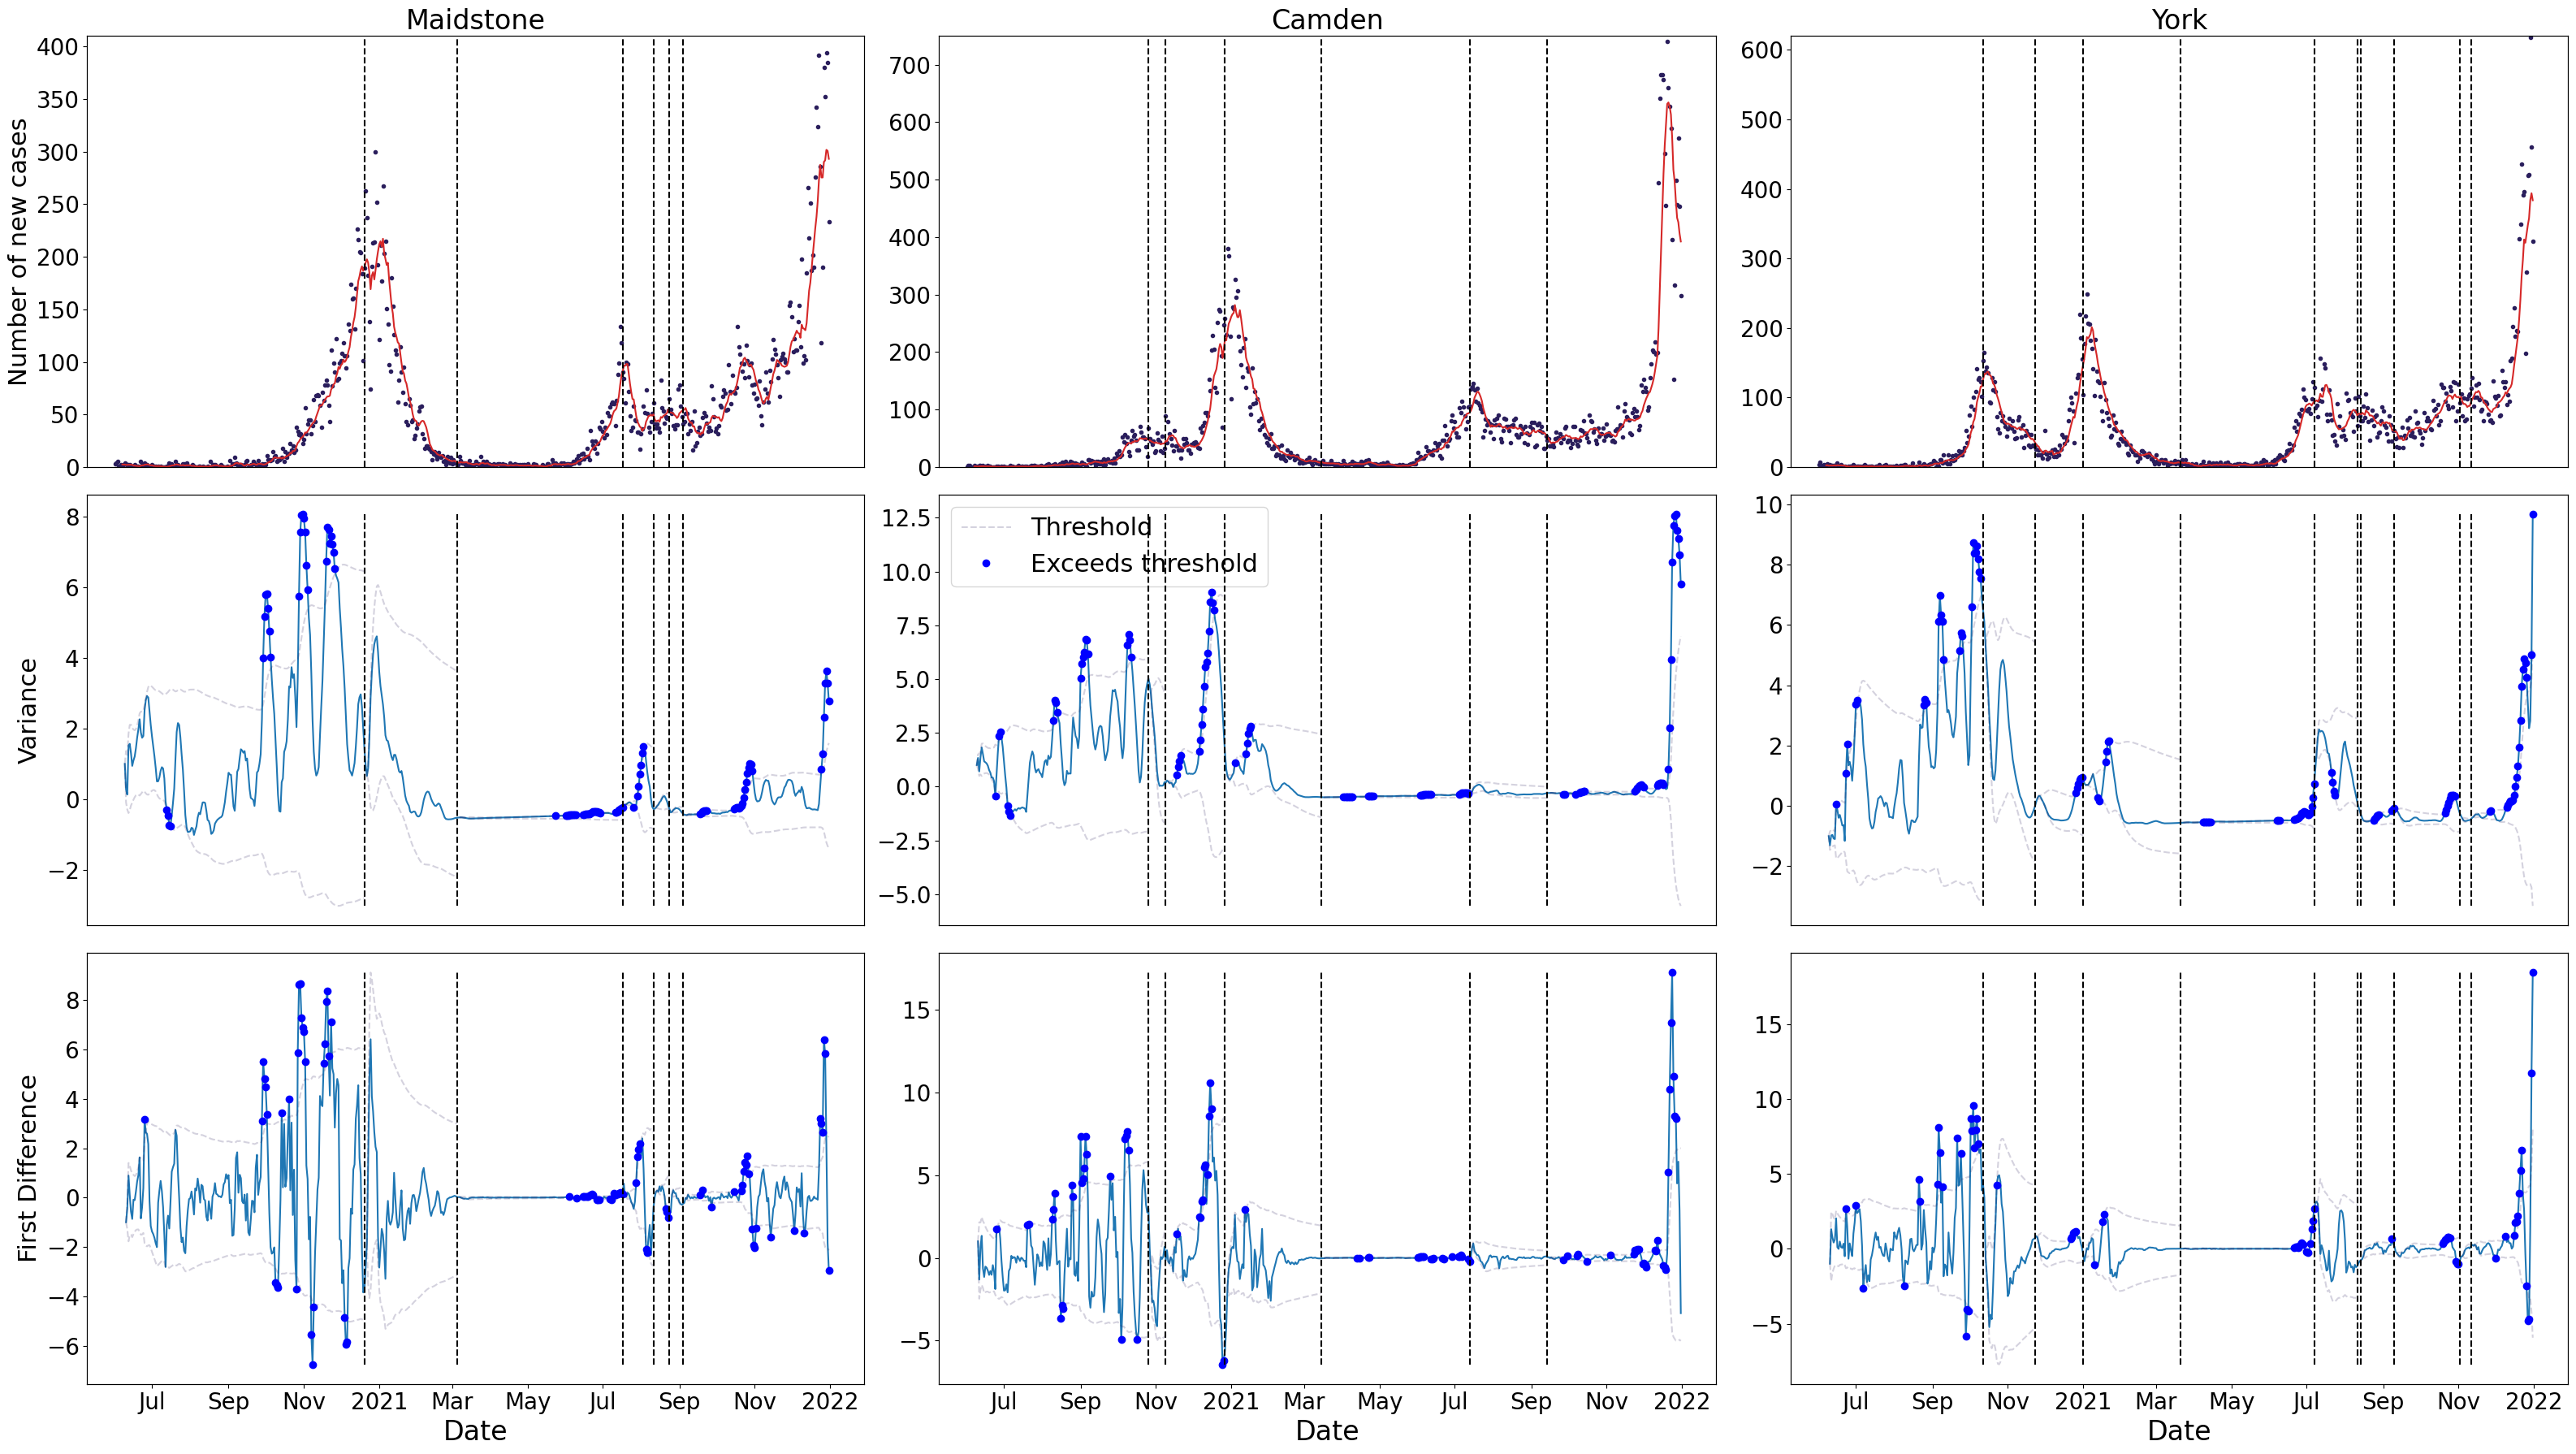

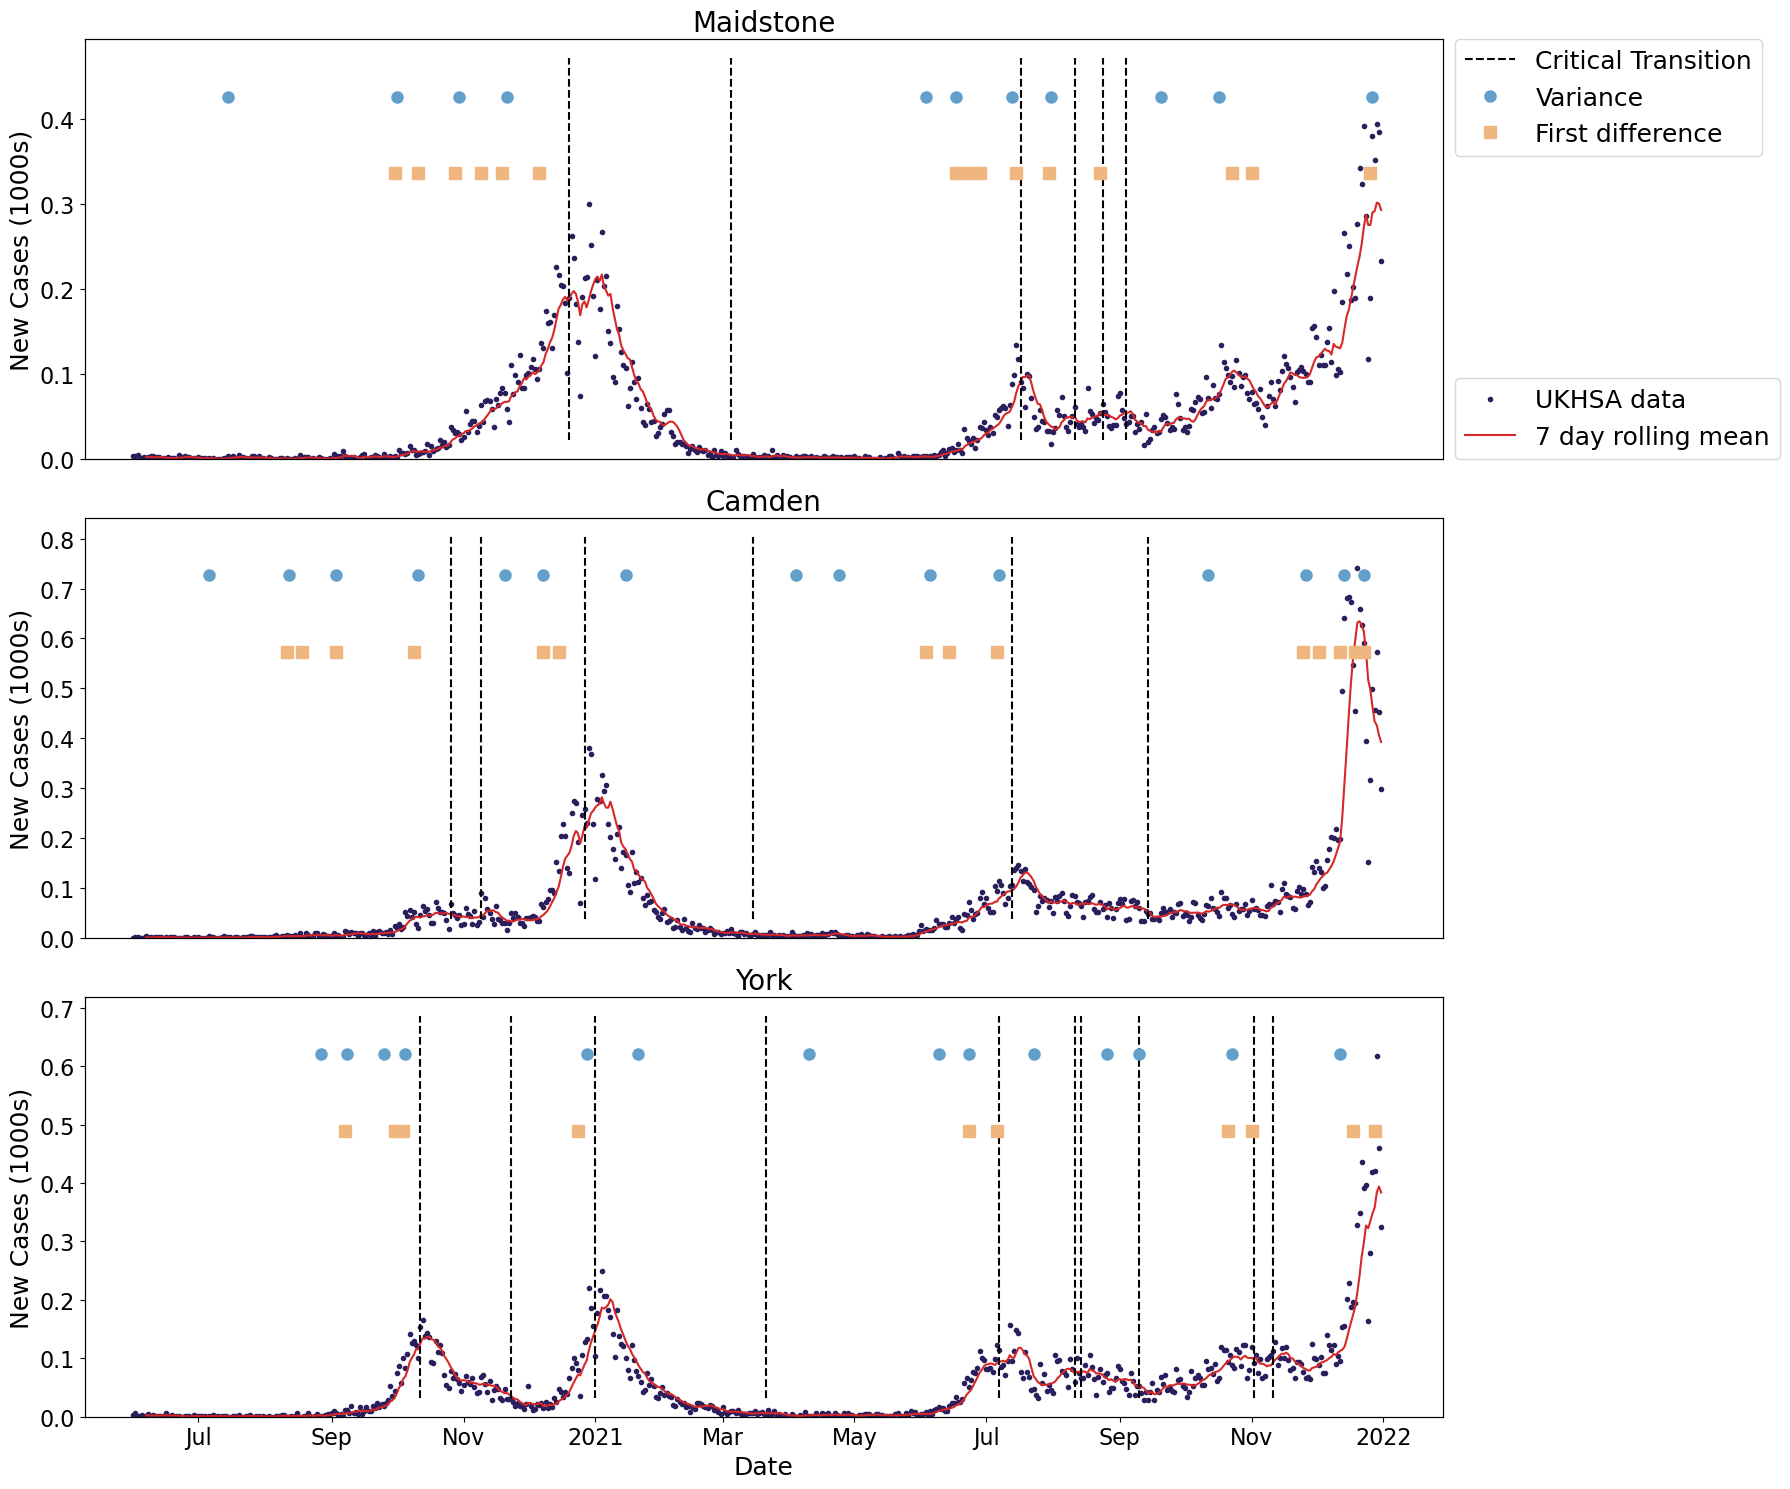

In [10]:
ews_dict = norm_ews_14total
areas = np.unique(ews_30total['variance'].columns.values)
ltlas = ['Maidstone','Camden','York']
two_sigma_cutoff, mean_dict, std_dict = loop_EWSs_store_results_cutoffs(ews_dict, areas, ltla_transitions)

detect_var = {}
detect_fd = {}

for area in areas:
    detect_var[area] = detect(two_sigma_cutoff['variance'][area])
    detect_fd[area] = detect(two_sigma_cutoff['first diff'][area])

stats = ['variance', 'first diff']
labs = ['Variance','First Difference']
fig, axs = plt.subplots(nrows=len(stats)+1,ncols=3,figsize=(32,18))
counts = cases[cases['area_name']=='Maidstone']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,0].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,0].plot(counts['date'],counts['rolling'],color='#D62828')
# counts.plot()
axs[0,0].set_ylim((0,410))
axs[0,0].set_title('Maidstone',fontsize=24)
counts = cases[cases['area_name']=='Camden']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,1].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,1].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,1].set_ylim((0,750))
axs[0,1].set_title('Camden',fontsize=24)
counts = cases[cases['area_name']=='York']
counts['rolling'] = counts['value'].rolling(7).mean()
counts = counts.reset_index()
axs[0,2].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,2].plot(counts['date'],counts['rolling'],color='#D62828')
axs[0,2].set_title('York',fontsize=24)
axs[0,2].set_ylim((0,620))
axs[0,0].set_ylabel('Number of new cases',fontsize=22)
ax = axs[0,0].twinx()
ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,1].twinx()
ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])
ax = axs[0,2].twinx()
ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',linestyle='--') 
ax.set_ylim((-1,1))
ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[0,i].xaxis.label.set_visible(False)
    axs[0,i].tick_params(axis='x', labelsize=20)
    axs[0,i].tick_params(axis='y', labelsize=20)

for i, stat in enumerate(stats):
    stat_data = norm_ews_14total[stat]
    y_data = stat_data['Maidstone'].copy(deep=True)
    std_val = std_dict[stat]['Maidstone']
    mean_val = mean_dict[stat]['Maidstone']
    axs[i+1,0].plot(y_data.reset_index()['date'],y_data.reset_index()['Maidstone'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,0].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,0].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Maidstone']].drop(columns=['Top','Bottom'])
    axs[i+1,0].plot(y_data['date'],y_data['Maidstone'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,0].xaxis.label.set_visible(False)
    axs[i+1,0].tick_params(axis='x', labelsize=20)
    axs[i+1,0].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,0].twinx()
    ax.vlines(x=ltla_transitions['Maidstone'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])    
    
for i, stat in enumerate(stats):
    stat_data = norm_ews_14total[stat]
    y_data = stat_data['Camden'].copy(deep=True)
    std_val = std_dict[stat]['Camden']
    mean_val = mean_dict[stat]['Camden']
    axs[i+1,1].plot(y_data.reset_index()['date'],y_data.reset_index()['Camden'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,1].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,1].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['Camden']].drop(columns=['Top','Bottom'])
    axs[i+1,1].plot(y_data['date'],y_data['Camden'],'o',color='blue',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,1].legend(fontsize=22)
    axs[i+1,1].xaxis.label.set_visible(False)
    axs[i+1,1].tick_params(axis='x', labelsize=20)
    axs[i+1,1].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,1].twinx()
    ax.vlines(x=ltla_transitions['Camden'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i, stat in enumerate(stats):
    stat_data = norm_ews_14total[stat]
    y_data = stat_data['York'].copy(deep=True)
    std_val = std_dict[stat]['York']
    mean_val = mean_dict[stat]['York']
    axs[i+1,2].plot(y_data.reset_index()['date'],y_data.reset_index()['York'])
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    axs[i+1,2].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
    axs[i+1,2].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
    y_data = y_data.iloc[two_sigma_cutoff[stat]['York']].drop(columns=['Top','Bottom'])
    axs[i+1,2].plot(y_data['date'],y_data['York'],'o',color='blue',label='Exceeds threshold')
    axs[i+1,2].xaxis.label.set_visible(False)
    axs[i+1,2].tick_params(axis='x', labelsize=20)
    axs[i+1,2].tick_params(axis='y', labelsize=20)
    ax = axs[i+1,2].twinx()
    ax.vlines(x=ltla_transitions['York'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')
    ax.get_yaxis().set_ticks([])

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=24)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

for i in range(1,3):
    axs[i,0].set_ylabel(labs[i-1],fontsize=22)

for i in range(3):
    for j in range(3):
        if i < 2:
            axs[i,j].set_xticks(())
        else:
            axs[i,j].xaxis.set_major_formatter(mdates.ConciseDateFormatter((axs[i,j].xaxis.get_major_locator())))
        axs[i,j].set_xlim((18391.4, 19020.6))

fig.tight_layout()
# plt.savefig("Figures/spatialrolling2sigmacutoff.pdf",dpi=2400,bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(3,1,figsize=(18,15))
for i, region in enumerate(ltlas):

    counts =  cases[cases['area_name']==region].reset_index()
    counts['value'] = counts['value'] / 1000
    counts['rolling'] = counts['value'].rolling(7).mean()
    axs[i].plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
    axs[i].plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
    axs[i].set_ylim([0,np.max(counts['value'].values)+0.1])
    axs[i].set_title(region,fontsize=20)
    # ax.get_yaxis().set_ticks([])
    axs[i].set_ylabel('New Cases (1000s)',fontsize=18)
    axs[i].tick_params(axis='y',labelsize=16)

    ax = axs[i].twinx()
    ax.vlines(x=ltla_transitions[region][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
    signal_data = norm_ews_14total['variance'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_var[region]]
    ax.plot(xs,[0.8]*len(xs),'o',color='#629FCA',markersize=8,label='Variance')

    signal_data = norm_ews_14total['first diff'][region]
    signal_data = signal_data.reset_index()
    xs = signal_data['date'][detect_fd[region]]
    ax.plot(xs,[0.4]*len(xs),'s',color='#F0B67F',markersize=8,label='First difference')

    ax.get_yaxis().set_ticks([])
    if i == 0:
        ax.legend(loc='upper left',fontsize = 18, bbox_to_anchor=(1, 1.03))

for i in range(3):
    axs[i].set_xlim(((18391.4, 19020.6)))
    if i < 2:
        axs[i].set_xticks(())
    else:
        axs[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[i].xaxis.get_major_locator()))
        axs[i].tick_params(axis='x', labelsize=16)
axs[0].legend(loc='lower left',fontsize = 18, bbox_to_anchor=(1, -0.03))
axs[-1].set_xlabel('Date',fontsize=18)
plt.tight_layout()
plt.savefig('Figures/ltla_timeline_14_days_outlegend.pdf',dpi=1200,bbox_inches='tight')
plt.show()